In [1]:
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from scipy import stats

## 사기 혐의자 데이터 읽기

In [23]:
# 보류
# 상담센터에 거래 관련 신고된 uid list
read_path = '../csv/help_uid.csv'
fraud_uid_help = pd.read_csv(read_path)

fraud_uid_help = fraud_uid_help.rename(columns={'value': 'uid'})

fraud_uid_help['uid'] = fraud_uid_help['uid'].astype(str)

fraud_uid_help['help'] = 1

fraud_uid_help.tail()

,uid,help
103113,1475933,1
103114,9313382,1
103115,9302282,1
103116,6223410,1
103117,9241528,1


In [24]:
# 상담센터 신고 내역 list
read_path = '../csv/help_reporter_frauder.csv'
help_raw = pd.read_csv(read_path)

help_raw.tail()

,discussion_id,created_at,reporter_uid,fraud_uid
197094,839197,2019-07-05 16:19:09,2343996,8275400
197095,839204,2019-07-05 16:32:55,4886388,0
197096,839205,2019-07-05 16:37:37,7211710,9266011
197097,839207,2019-07-05 16:39:02,6721678,9331943
197098,839209,2019-07-05 16:40:48,3203974,8659585


,fraud_uid,frauder
103364,Keycaps,1
103365,UI-Return,1
103366,UIKBInputBackdropView:0x151259440.Height{id: 5...,1
103367,fontName: com.apple.kUIFontMagicSystemFontName...,1
103368,undefined,1


In [26]:
# 영구 제재 받은 uid list
read_path = '../csv/block_uid.csv'
fraud_uid_block = pd.read_csv(read_path)

fraud_uid_block['block'] = 1

fraud_uid_block['uid'] = fraud_uid_block['uid'].astype(str)

fraud_uid_block.tail()

,uid,block
143847,5834292,1
143848,5067006,1
143849,8755369,1
143850,5083812,1
143851,7961342,1


In [27]:
# 운영팀에서 관리하는 거래신고 접수 uid
read_path = '../csv/fraud_report_data_2019_2016.csv'
fraud_operation = pd.read_csv(read_path)

fraud_operation.columns = ['reported_date', 'product_name', 'price', 'reporter_uid', 'fraud_uid']

fraud_operation['block_by_operation'] = 1

fraud_operation.tail()

,reported_date,product_name,price,reporter_uid,fraud_uid,block_by_operation
15951,NaN,갤럭시A7,"125,000",1370542.0,2667809,1
15952,NaN,갤럭시노트fe,"350,000",3224068.0,4087003,1
15953,NaN,아이폰5s,"123,000",4016158.0,4770542,1
15954,NaN,핸드백,"25,000",938074.0,5335535,1
15955,NaN,gtx1060 6g,"250,000",1890173.0,5699420,1


### 사기 혐의자 데이터 합치기

In [28]:
fraud_uid_operation = fraud_operation[['fraud_uid', 'block_by_operation']]

fraud_uid_operation = fraud_uid_operation.rename(columns={'fraud_uid': 'uid'})

fraud_uid_operation['uid'] = fraud_uid_operation['uid'].astype(str)

fraud_uid_operation.tail()

,uid,block_by_operation
15951,2667809,1
15952,4087003,1
15953,4770542,1
15954,5335535,1
15955,5699420,1


In [29]:
fraud_uid_1 = pd.merge(fraud_uid_help, fraud_uid_block, on='uid', how='outer')

fraud_uid = pd.merge(fraud_uid_1, fraud_uid_operation, on='uid', how='outer')

fraud_uid = fraud_uid.fillna(0)

fraud_uid.tail()

,uid,help,block,block_by_operation
212508,6534153,0.0,0.0,1.0
212509,2610325,0.0,0.0,1.0
212510,3927135,0.0,0.0,1.0
212511,1806746,0.0,0.0,1.0
212512,8970553,0.0,0.0,1.0


In [30]:
def merge_block(row):
    if row['help'] == 1 and row['block'] == 1 and row['block_by_operation'] == 1:
        return 'help&block&operation'
    elif row['help'] == 1 and row['block'] == 1:
        return 'help&block'
    elif row['block'] == 1 and row['block_by_operation'] == 1:
        return 'block&operation'
    elif row['help'] == 1 and row['block_by_operation'] == 1:
        return 'help&operation'
    elif row['help'] == 1:
        return 'help'
    elif row['block'] == 1:
        return 'block'
    elif row['block_by_operation'] == 1:
        return 'operation'
    else:
        return 'missing'
    
fraud_uid['black_source'] = fraud_uid.apply(merge_block, axis=1)

# save
save_path = '../csv/tmp/fraud_uid.csv'
fraud_uid.to_csv(save_path, index=False, mode='w', header=True)

fraud_uid.tail()

,uid,help,block,block_by_operation,black_source
212508,6534153,0.0,0.0,1.0,operation
212509,2610325,0.0,0.0,1.0,operation
212510,3927135,0.0,0.0,1.0,operation
212511,1806746,0.0,0.0,1.0,operation
212512,8970553,0.0,0.0,1.0,operation


In [31]:
fraud_uid.groupby(['black_source'], as_index=False).agg({'uid':'count'})

,black_source,uid
0,block,103892
1,block&operation,826
2,help,63073
3,help&block,29592
4,help&block&operation,12952
5,help&operation,1005
6,operation,1173


## 거래 데이터 읽기

In [19]:
# 보류
# 번개페이 거래 데이터
read_path = '../csv/pay_history.csv'
pay_raw = pd.read_csv(read_path)

pay_raw = pay_raw.rename(columns={'buyer_id': 'buyer_uid', 'seller_id': 'seller_uid', 'deposit_done_date': 'updated_at'})

pay_raw.tail()

,updated_at,buyer_uid,seller_uid,total_price
90146,2019-01-25 20:32:45,4161761,4414597,148170
90147,2019-02-01 20:31:30,603779,5071323,31450
90148,2019-01-25 20:32:45,8069149,7742258,47350
90149,2019-01-25 20:32:45,31040,2459314,143100
90150,2019-01-25 20:32:45,7526483,7566393,2576000


In [38]:
# 번프 완료 데이터
read_path = '../csv/bunp_history.csv'
bunp_raw = pd.read_csv(read_path)

bunp_raw = bunp_raw.rename(columns={'seller_pid_price': 'total_price'})

bunp_raw.tail()

,updated_at,category,buyer_uid,seller_uid,total_price
10933687,2019-07-02 09:22:43,600700002,428300,9139471,20000
10933688,2019-07-02 10:07:24,900220999,4583984,3727301,24000
10933689,2019-07-02 11:42:04,700100100,9303879,5499956,80000
10933690,2019-07-02 13:10:52,400010100,8693877,5293606,38000
10933691,2019-07-02 13:15:25,600700999,5696564,9138584,70000


In [32]:
# 보류
# 번개페이와 번프 합치기
transaction = pd.concat([bunp_raw, pay_raw], axis=0).reset_index()

transaction['seller_uid'] = transaction['seller_uid'].astype(str)

# 거래 데이터와 사기자 데이터 합치기
transaction_black = pd.merge(transaction, fraud_uid[['uid', 'black_source']], 
                             left_on=['seller_uid'], right_on=['uid'], how='left')

transaction_black.tail()

/Users/quicket/python-bunjang/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,index,buyer_uid,category,seller_uid,total_price,updated_at,uid,black_source
11179545,90146,4161761,NaN,4414597,148170,2019-01-25 20:32:45,4414597,help
11179546,90147,603779,NaN,5071323,31450,2019-02-01 20:31:30,NaN,NaN
11179547,90148,8069149,NaN,7742258,47350,2019-01-25 20:32:45,NaN,NaN
11179548,90149,31040,NaN,2459314,143100,2019-01-25 20:32:45,NaN,NaN
11179549,90150,7526483,NaN,7566393,2576000,2019-01-25 20:32:45,NaN,NaN


### 카테고리 테이블

In [33]:
read_path = '../csv/categories.csv'
df_category = pd.read_csv(read_path)

df_category['category'] = df_category['category'].astype(str)

df_category = df_category[['category', 'name']]

df_category.tail()

,category,name
1219,240060020,프로그래머
1220,240070040,설문조사
1221,240080060,유아유치원
1222,240100010,매장관리
1223,240100090,기타 업종


### 전체 번프 대비 사기 유형별 금액, 건 수 비율

In [16]:
bunp_raw['category_3'] = bunp_raw['category'].astype(str).str[:3]

In [17]:
bunp_raw['seller_uid'] = bunp_raw['seller_uid'].astype(str)

bunp_fraud_1 = pd.merge(bunp_raw, fraud_uid, 
                             left_on=['seller_uid'], right_on=['uid'], how='left')

bunp_fraud_1['category'] = bunp_fraud_1['category'].astype(str)

bunp_fraud = pd.merge(bunp_fraud_1, df_category, left_on='category_3', right_on='category', how='left')

bunp_fraud = bunp_fraud.fillna(0).drop(['uid'], axis=1)

bunp_fraud['month_at'] = bunp_fraud['updated_at'].astype(str).str[:7]

bunp_fraud.tail()

,updated_at,category_x,buyer_uid,seller_uid,total_price,category_3,help,block,block_by_operation,black_source,category_y,name,month_at
11088665,2019-07-02 09:22:43,600700002,428300,9139471,20000,600,0.0,0.0,0.0,0,600,디지털/가전,2019-07
11088666,2019-07-02 10:07:24,900220999,4583984,3727301,24000,900,0.0,0.0,0.0,0,900,도서/티켓/취미/애완,2019-07
11088667,2019-07-02 11:42:04,700100100,9303879,5499956,80000,700,0.0,0.0,0.0,0,700,스포츠/레저,2019-07
11088668,2019-07-02 13:10:52,400010100,8693877,5293606,38000,400,1.0,0.0,0.0,help,400,패션잡화,2019-07
11088669,2019-07-02 13:15:25,600700999,5696564,9138584,70000,600,1.0,1.0,0.0,help&block,600,디지털/가전,2019-07


In [18]:
bunp_fraud_agg = bunp_fraud.groupby(['month_at', 'name','black_source'], as_index=False).agg({'total_price': 'sum', 'updated_at': 'count'})

# save
save_path = '../csv/tmp/bunp_fraud_agg.csv'
bunp_fraud_agg.to_csv(save_path, index=False, mode='w', header=True)

bunp_fraud_agg.tail()

,month_at,name,black_source,total_price,updated_at
3481,2019-07,패션잡화,help,54521212,564
3482,2019-07,패션잡화,help&block,3746500,19
3483,2019-07,패션잡화,help&block&operation,97000,4
3484,2019-07,패션잡화,help&operation,712504,11
3485,2019-07,패션잡화,operation,50000,1


In [166]:
# 운영팀에서 관리하는 거래신고 접수 uid
read_path = '../csv/fraud_report_data_2019_2016.csv'
fraud_operation = pd.read_csv(read_path)

fraud_operation.columns = ['reported_date', 'product_name', 'price', 'reporter_uid', 'fraud_uid']

fraud_operation['block_by_operation'] = 1

fraud_operation.tail()

,reported_date,product_name,price,reporter_uid,fraud_uid,block_by_operation
15951,NaN,갤럭시A7,"125,000",1370542.0,2667809,1
15952,NaN,갤럭시노트fe,"350,000",3224068.0,4087003,1
15953,NaN,아이폰5s,"123,000",4016158.0,4770542,1
15954,NaN,핸드백,"25,000",938074.0,5335535,1
15955,NaN,gtx1060 6g,"250,000",1890173.0,5699420,1


In [167]:
# 운영팀에서 관리하는 거래신고 접수 uid
fraud_operation.tail()

,reported_date,product_name,price,reporter_uid,fraud_uid,block_by_operation
15951,NaN,갤럭시A7,"125,000",1370542.0,2667809,1
15952,NaN,갤럭시노트fe,"350,000",3224068.0,4087003,1
15953,NaN,아이폰5s,"123,000",4016158.0,4770542,1
15954,NaN,핸드백,"25,000",938074.0,5335535,1
15955,NaN,gtx1060 6g,"250,000",1890173.0,5699420,1


In [7]:
# 2017년 이후 신고 데이터만 남기기

fraud_operation_17 = fraud_operation.dropna(subset=['reported_date']).reset_index()

fraud_operation_17['year'] = fraud_operation_17['reported_date'].astype(str).str[:4]

fraud_operation_17['year'] = fraud_operation_17['year'].astype(int)

fraud_operation_17 = fraud_operation_17[fraud_operation_17['year'] >= 2017].reset_index()

fraud_operation_17.tail()

NameError: name 'fraud_operation' is not defined

In [96]:
# 전체 번프 내역
read_path = '../csv/bunp_history_all.csv'
bunp_raw_all = pd.read_csv(read_path)

bunp_raw_all = bunp_raw_all.rename(columns={'seller_pid_price': 'total_price'})

bunp_raw_all.tail()

,updated_at,category,status,buyer_uid,seller_uid,total_price
14358263,2019-07-02 13:40:26,800300001,1,9177490,4019525,64500
14358264,2019-07-02 13:47:20,910100008,2,6642640,5771737,42000
14358265,2019-07-02 13:47:50,310040030,0,459089,4222905,17000
14358266,2019-07-02 13:48:06,400010999,0,2514394,6464324,22000
14358267,2019-07-02 13:48:43,400083999,1,9177095,4277306,5000


In [97]:
# 2017년 이후 번프 내역
bunp_raw_all_17 = bunp_raw_all

bunp_raw_all_17['year'] = bunp_raw_all_17['updated_at'].astype(str).str[:4]

bunp_raw_all_17['year'] = bunp_raw_all_17['year'].astype(int)

bunp_raw_all_17 = bunp_raw_all_17[bunp_raw_all_17['year'] >= 2017].reset_index()

bunp_raw_all_17.tail()

,index,updated_at,category,status,buyer_uid,seller_uid,total_price,year
14148222,14358263,2019-07-02 13:40:26,800300001,1,9177490,4019525,64500,2019
14148223,14358264,2019-07-02 13:47:20,910100008,2,6642640,5771737,42000,2019
14148224,14358265,2019-07-02 13:47:50,310040030,0,459089,4222905,17000,2019
14148225,14358266,2019-07-02 13:48:06,400010999,0,2514394,6464324,22000,2019
14148226,14358267,2019-07-02 13:48:43,400083999,1,9177095,4277306,5000,2019


In [42]:
# change type to str
for col in ['reporter_uid', 'fraud_uid']:
    fraud_operation_17[col] = fraud_operation_17[col].fillna(0.0).astype(int)
    fraud_operation_17[col] = fraud_operation_17[col].astype('str')

for col in ['buyer_uid', 'seller_uid']:
    bunp_raw_all_17[col] = bunp_raw_all_17[col].astype('str')

# merge
bunp_fraud_event = pd.merge(bunp_raw_all_17, fraud_operation_17, 
                            left_on=['buyer_uid', 'seller_uid'],
                            right_on=['reporter_uid', 'fraud_uid'],
                            how='left')

bunp_fraud_event['block_by_operation'] = bunp_fraud_event['block_by_operation'].fillna(0)

bunp_fraud_event.tail()

NameError: name 'fraud_operation_17' is not defined

In [179]:
bunp_fraud_event.groupby(['block_by_operation'], as_index=False).agg({'total_price': 'sum', 
                                                                      'updated_at': 'count'})

,block_by_operation,total_price,updated_at
0,0.0,6608584786662,14141804
1,1.0,6484772397,6450


In [180]:
bunp_fraud_event['month_at'] = bunp_fraud_event['updated_at'].astype(str).str[:7]

bunp_fraud_event_agg = bunp_fraud_event.groupby(['month_at','block_by_operation'], as_index=False).agg({'total_price': 'sum', 'updated_at': 'count'})

# save
save_path = '../csv/tmp/bunp_fraud_event_agg.csv'
bunp_fraud_event_agg.to_csv(save_path, index=False, mode='w', header=True)

bunp_fraud_event_agg.tail()

,month_at,block_by_operation,total_price,updated_at
56,2019-05,0.0,213124122615,522256
57,2019-05,1.0,26486400,174
58,2019-06,0.0,236712136327,553476
59,2019-06,1.0,1709000,12
60,2019-07,0.0,21424284223,49308


### 2017년 이후 번프 중 상담센터 신고내역

In [103]:
# 거래관련 상담센터 신고 list
read_path = '../csv/help_reporter_frauder.csv'
help_raw = pd.read_csv(read_path)

help_raw['fraud_help'] = 1

help_raw.tail()

,discussion_id,created_at,reporter_uid,fraud_uid,fraud_help
197094,839197,2019-07-05 16:19:09,2343996,8275400,1
197095,839204,2019-07-05 16:32:55,4886388,0,1
197096,839205,2019-07-05 16:37:37,7211710,9266011,1
197097,839207,2019-07-05 16:39:02,6721678,9331943,1
197098,839209,2019-07-05 16:40:48,3203974,8659585,1


In [104]:
help_raw = help_raw.sort_values(['reporter_uid', 'fraud_uid', 'created_at'])  # sort again, ascending

help_raw = help_raw.drop_duplicates(['reporter_uid', 'fraud_uid'])  # drop duplicated row, keep 1st row

help_raw.tail()

,discussion_id,created_at,reporter_uid,fraud_uid,fraud_help
197015,838830,2019-07-05 07:56:30,9317104,0,1
196983,838715,2019-07-04 23:36:37,9317700,8767099,1
196782,837888,2019-07-03 21:12:13,9322294,0,1
196784,837893,2019-07-03 21:17:22,9322294,9320707,1
196876,838255,2019-07-04 13:55:10,9323927,4623330,1


In [119]:
# 상담센터 신고 내역 list의 신고 대상자
help_raw_frauder = help_raw.groupby(['fraud_uid'], as_index=False).count()

help_raw_frauder = pd.DataFrame(help_raw_frauder['fraud_uid'])

help_raw_frauder = help_raw_frauder[(help_raw_frauder['fraud_uid'] != '0') & (help_raw_frauder['fraud_uid'] != '1')]

help_raw_frauder['frauder'] = 1

help_raw_frauder.tail()

,fraud_uid,frauder
103364,Keycaps,1
103365,UI-Return,1
103366,UIKBInputBackdropView:0x151259440.Height{id: 5...,1
103367,fontName: com.apple.kUIFontMagicSystemFontName...,1
103368,undefined,1


In [121]:
# change type to str
for col in ['reporter_uid', 'fraud_uid']:
    
    df = help_raw
    
    df[col] = df[col].astype('str')

for col in ['buyer_uid', 'seller_uid']:
    
    df = bunp_raw_all_17
    
    df[col] = df[col].astype('str')

# merge
bunp_help_event = pd.merge(bunp_raw_all_17, help_raw, 
                            left_on=['buyer_uid', 'seller_uid'],
                            right_on=['reporter_uid', 'fraud_uid'],
                            how='left')


bunp_help_event['fraud_help'] = bunp_help_event['fraud_help'].fillna(0)

bunp_help_event['month_at'] = bunp_help_event['updated_at'].astype(str).str[:7]


# 1-depth 카테고리 붙이기
bunp_help_event['category_3'] = bunp_help_event['category'].astype(str).str[:3]

bunp_help_event = pd.merge(bunp_help_event, df_category, left_on='category_3', right_on='category', how='left')

# drop columns
bunp_help_event = bunp_help_event.drop(['index', 'category_x', 'year', 'discussion_id'], axis=1)

bunp_help_event.tail()

,updated_at,status,buyer_uid,seller_uid,total_price,created_at,reporter_uid,fraud_uid,fraud_help,month_at,category_3,category_y,name
14148222,2019-07-02 13:40:26,1,9177490,4019525,64500,NaN,NaN,NaN,0.0,2019-07,800,800,생활/문구/가구/식품
14148223,2019-07-02 13:47:20,2,6642640,5771737,42000,NaN,NaN,NaN,0.0,2019-07,910,910,스타굿즈
14148224,2019-07-02 13:47:50,0,459089,4222905,17000,NaN,NaN,NaN,0.0,2019-07,310,310,여성의류
14148225,2019-07-02 13:48:06,0,2514394,6464324,22000,NaN,NaN,NaN,0.0,2019-07,400,400,패션잡화
14148226,2019-07-02 13:48:43,1,9177095,4277306,5000,NaN,NaN,NaN,0.0,2019-07,400,400,패션잡화


In [122]:
def categorize_price(row):
    if row['total_price'] <= 30000:
        return 'less_3'
    elif row['total_price'] <= 50000:
        return 'less_5'
    elif row['total_price'] <= 100000:
        return 'less_10'
    elif row['total_price'] <= 300000:
        return 'less_30'
    elif row['total_price'] <= 3000000:
        return 'less_300'
    else:
        return 'more_300'

        
bunp_help_event['price_range'] = bunp_help_event.apply(categorize_price, axis=1)

bunp_help_event.tail()

,updated_at,status,buyer_uid,seller_uid,total_price,created_at,reporter_uid,fraud_uid,fraud_help,month_at,category_3,category_y,name,price_range
14148222,2019-07-02 13:40:26,1,9177490,4019525,64500,NaN,NaN,NaN,0.0,2019-07,800,800,생활/문구/가구/식품,less_10
14148223,2019-07-02 13:47:20,2,6642640,5771737,42000,NaN,NaN,NaN,0.0,2019-07,910,910,스타굿즈,less_5
14148224,2019-07-02 13:47:50,0,459089,4222905,17000,NaN,NaN,NaN,0.0,2019-07,310,310,여성의류,less_3
14148225,2019-07-02 13:48:06,0,2514394,6464324,22000,NaN,NaN,NaN,0.0,2019-07,400,400,패션잡화,less_3
14148226,2019-07-02 13:48:43,1,9177095,4277306,5000,NaN,NaN,NaN,0.0,2019-07,400,400,패션잡화,less_3


In [123]:
bunp_help_event = pd.merge(bunp_help_event, help_raw_frauder, 
                           left_on='seller_uid', right_on='fraud_uid', 
                          how='left')

bunp_help_event['frauder'] = bunp_help_event['frauder'].fillna(0)

bunp_help_event.tail()

,updated_at,status,buyer_uid,seller_uid,total_price,created_at,reporter_uid,fraud_uid_x,fraud_help,month_at,category_3,category_y,name,price_range,fraud_uid_y,frauder
14148222,2019-07-02 13:40:26,1,9177490,4019525,64500,NaN,NaN,NaN,0.0,2019-07,800,800,생활/문구/가구/식품,less_10,NaN,0.0
14148223,2019-07-02 13:47:20,2,6642640,5771737,42000,NaN,NaN,NaN,0.0,2019-07,910,910,스타굿즈,less_5,5771737,1.0
14148224,2019-07-02 13:47:50,0,459089,4222905,17000,NaN,NaN,NaN,0.0,2019-07,310,310,여성의류,less_3,4222905,1.0
14148225,2019-07-02 13:48:06,0,2514394,6464324,22000,NaN,NaN,NaN,0.0,2019-07,400,400,패션잡화,less_3,6464324,1.0
14148226,2019-07-02 13:48:43,1,9177095,4277306,5000,NaN,NaN,NaN,0.0,2019-07,400,400,패션잡화,less_3,NaN,0.0


In [124]:
bunp_help_event_agg = bunp_help_event.groupby(['month_at',
                                               'category_3',
                                               'name',
                                               'price_range',
                                               'frauder',
                                               'fraud_help'], as_index=False).agg({'total_price': 'sum', 
                                                                                   'updated_at': 'count'})

# save
save_path = '../csv/tmp/bunp_help_event_agg.csv'
bunp_help_event_agg.to_csv(save_path, index=False, mode='w', header=True)

bunp_help_event_agg.tail()

,month_at,category_3,name,price_range,frauder,fraud_help,total_price,updated_at
7447,2019-07,999,기타,less_5,0.0,0.0,7741900,183
7448,2019-07,999,기타,less_5,1.0,0.0,878000,22
7449,2019-07,999,기타,less_5,1.0,1.0,86000,2
7450,2019-07,999,기타,more_300,0.0,0.0,21149999,4
7451,2019-07,999,기타,more_300,1.0,0.0,100000000,1


In [76]:
bunp_help_fraud = bunp_help_event[bunp_help_event['fraud_help'] == 1]

bunp_help_fraud.reset_index().tail()

,index,updated_at,status,buyer_uid,seller_uid,total_price,created_at,reporter_uid,fraud_uid_x,fraud_help,month_at,category_3,category_y,name,price_range,fraud_uid_y,frauder
62877,14157966,2019-06-28 08:35:54,1,9127162,2870085,30000,2019-06-29 14:45:34,9127162,2870085,1.0,2019-06,600,600,디지털/가전,less_3,2870085,1.0
62878,14158267,2019-06-29 14:20:16,1,4853073,6483740,40000,2019-06-29 14:25:42,4853073,6483740,1.0,2019-06,600,600,디지털/가전,less_5,6483740,1.0
62879,14158586,2019-06-30 03:19:56,1,4576400,3135477,70000,2019-07-01 14:19:17,4576400,3135477,1.0,2019-06,900,900,도서/티켓/취미/애완,less_10,3135477,1.0
62880,14158642,2019-06-30 15:51:01,2,3384928,2760802,20000,2019-07-02 19:22:50,3384928,2760802,1.0,2019-06,320,320,남성의류,less_3,2760802,1.0
62881,14158666,2019-06-30 18:12:16,1,8811213,4207849,4500,2019-07-02 02:36:32,8811213,4207849,1.0,2019-06,910,910,스타굿즈,less_3,4207849,1.0


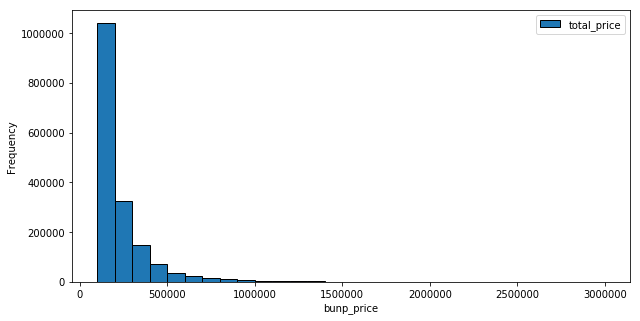

In [142]:
# 히스토그램 그리기

import matplotlib.pylab as plt
import numpy as np

bunp_help_event['total_price'].plot(kind="hist", range = (100000, 3000000), bins = 29, edgecolor ="black", figsize = (10, 5))

plt.legend()

# plt.title("Histogram Example")
plt.xlabel("bunp_price")

plt.show()

In [139]:
bunp_help_fraud.tail()

,updated_at,status,buyer_uid,seller_uid,total_price,created_at,reporter_uid,fraud_uid_x,fraud_help,month_at,category_3,category_y,name,price_range,fraud_uid_y,frauder,total_price_10
14157966,2019-06-28 08:35:54,1,9127162,2870085,30000,2019-06-29 14:45:34,9127162,2870085,1.0,2019-06,600,600,디지털/가전,less_3,2870085,1.0,0.0
14158267,2019-06-29 14:20:16,1,4853073,6483740,40000,2019-06-29 14:25:42,4853073,6483740,1.0,2019-06,600,600,디지털/가전,less_5,6483740,1.0,0.0
14158586,2019-06-30 03:19:56,1,4576400,3135477,70000,2019-07-01 14:19:17,4576400,3135477,1.0,2019-06,900,900,도서/티켓/취미/애완,less_10,3135477,1.0,0.0
14158642,2019-06-30 15:51:01,2,3384928,2760802,20000,2019-07-02 19:22:50,3384928,2760802,1.0,2019-06,320,320,남성의류,less_3,2760802,1.0,0.0
14158666,2019-06-30 18:12:16,1,8811213,4207849,4500,2019-07-02 02:36:32,8811213,4207849,1.0,2019-06,910,910,스타굿즈,less_3,4207849,1.0,0.0


In [143]:
bunp_help_event['total_price_10'] = (bunp_help_event['total_price'] / 100000).apply(np.floor) * 100000

bunp_help_event_agg_1 = bunp_help_event.groupby(['total_price_10', 
                                                 'fraud_help'], as_index=False).agg({'total_price': 'sum', 
                                                                                   'updated_at': 'count'})

# save
save_path = '../csv/tmp/bunp_help_event_agg_1.csv'
bunp_help_event_agg_1.to_csv(save_path, index=False, mode='w', header=True)

bunp_help_event_agg_1.tail()

,total_price_10,fraud_help,total_price,updated_at
835,4.009900e+09,0.0,4009915000,1
836,4.200000e+09,0.0,4200000000,1
837,4.272200e+09,0.0,4272205737,1
838,4.294900e+09,0.0,3792456121485,883
839,4.294900e+09,1.0,8589934590,2


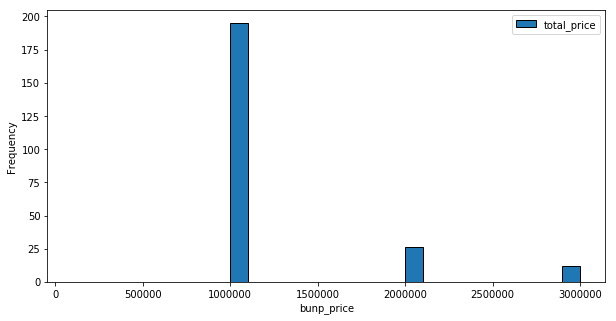

In [132]:
x = (bunp_help_fraud['total_price'] / 100000).apply(np.floor) * 100000



# 히스토그램 그리기

import matplotlib.pylab as plt
import numpy as np

x.plot(kind="hist", range = (100000, 3000000), bins = 29, edgecolor ="black", figsize = (10, 5))

plt.legend()

# plt.title("Histogram Example")
plt.xlabel("bunp_price")

plt.show()

# 변수 기초 데이터 읽기

### 이름 변경 내역 파일 읽기

In [120]:
read_path = '../csv/changed_name.csv'
fraud_name = pd.read_csv(read_path)

fraud_name['is_black'] = fraud_name['is_black'].replace('normal', 0)
fraud_name['is_black'] = fraud_name['is_black'].replace('black', 1)

fraud_name.tail()

,is_black,uid,changed_name
4095222,0,9315495,1
4095223,0,9315496,1
4095224,0,9315512,1
4095225,0,9315513,1
4095226,0,9315544,1


### T-Test

In [121]:
fraud_name_normal = fraud_name[fraud_name['is_black'] == 0]
fraud_name_black = fraud_name[fraud_name['is_black'] == 1]

In [122]:
# 샘플 수 비교
np.size(fraud_name_normal['changed_name']), np.size(fraud_name_black['changed_name'])

(3983427, 111800)

In [123]:
# 평균 비교
np.mean(fraud_name_normal['changed_name']), np.mean(fraud_name_black['changed_name'])

(1.4122430259171312, 1.7182200357781754)

In [124]:
tTestResultName = stats.ttest_ind(fraud_name_normal['changed_name'], fraud_name_black['changed_name'], equal_var=False)

tTestResultName

Ttest_indResult(statistic=-62.24629954059341, pvalue=0.0)

### 폰 변경 내역 파일 읽기

In [ ]:
read_path = '../csv/changed_phone.csv'
fraud_phone = pd.read_csv(read_path)

fraud_phone['is_black'] = fraud_phone['is_black'].replace('normal', 0)
fraud_phone['is_black'] = fraud_phone['is_black'].replace('black', 1)

fraud_phone.tail()

### T-Test

In [ ]:
fraud_phone_normal = fraud_phone[fraud_phone['is_black'] == 0]
fraud_phone_black = fraud_phone[fraud_phone['is_black'] == 1]

In [ ]:
# 샘플 수 비교
np.size(fraud_phone_normal['changed_phone']), np.size(fraud_phone_black['changed_phone'])

In [ ]:
# 평균 비교
np.mean(fraud_phone_normal['changed_phone']), np.mean(fraud_phone_black['changed_phone'])

In [ ]:
tTestResultPhone = stats.ttest_ind(fraud_phone_normal['changed_phone'], fraud_phone_black['changed_phone'], equal_var=False)

tTestResultPhone

### 리뷰 받은 사람 파일 읽기

In [125]:
read_path = '../csv/review_ee.csv'
fraud_review_ee = pd.read_csv(read_path)

fraud_review_ee['is_black'] = fraud_review_ee['is_black'].replace('normal', 0)
fraud_review_ee['is_black'] = fraud_review_ee['is_black'].replace('black', 1)

fraud_review_ee = fraud_review_ee.rename(columns={'shop_uid': 'uid'})

fraud_review_ee.tail()

,is_black,uid,review
960295,0,9303612,1
960296,0,9305161,1
960297,0,9310247,1
960298,0,9310368,1
960299,0,9313138,1


### T-Test

In [126]:
fraud_review_ee_normal = fraud_review_ee[fraud_review_ee['is_black'] == 0]
fraud_review_ee_black = fraud_review_ee[fraud_review_ee['is_black'] == 1]

In [127]:
# 샘플 수 비교
np.size(fraud_review_ee_normal['review']), np.size(fraud_review_ee_black['review'])

(897324, 62976)

In [128]:
# 평균 비교
np.mean(fraud_review_ee_normal['review']), np.mean(fraud_review_ee_black['review'])

(5.97372520962328, 8.573234247967479)

In [129]:
tTestResultReviewEe = stats.ttest_ind(fraud_review_ee_normal['review'], fraud_review_ee_black['review'], equal_var=False)

tTestResultReviewEe

Ttest_indResult(statistic=-23.21982978574343, pvalue=7.980710979230879e-119)

### 리뷰 남긴 사람 파일 읽기

In [130]:
read_path = '../csv/review_er.csv'
fraud_review_er = pd.read_csv(read_path)

fraud_review_er['is_black'] = fraud_review_er['is_black'].replace('normal', 0)
fraud_review_er['is_black'] = fraud_review_er['is_black'].replace('black', 1)

fraud_review_er = fraud_review_er.rename(columns={'writer_uid': 'uid'})

fraud_review_er.tail()

,is_black,uid,review
1109973,0,9309329,1
1109974,0,9309339,1
1109975,0,9309423,1
1109976,0,9311843,1
1109977,0,9313932,1


### T-Test

In [131]:
fraud_review_er_normal = fraud_review_er[fraud_review_er['is_black'] == 0]
fraud_review_er_black = fraud_review_er[fraud_review_er['is_black'] == 1]

In [132]:
# 샘플 수 비교
np.size(fraud_review_er_normal['review']), np.size(fraud_review_er_black['review'])

(1058974, 51004)

In [133]:
# 평균 비교
np.mean(fraud_review_er_normal['review']), np.mean(fraud_review_er_black['review'])

(5.215598305529692, 7.393478942828014)

In [134]:
tTestResultReviewEr = stats.ttest_ind(fraud_review_er_normal['review'], fraud_review_er_black['review'], equal_var=False)

tTestResultReviewEr

Ttest_indResult(statistic=-25.846254524648977, pvalue=2.049059005337516e-146)

# 데이터 merge

In [ ]:
fraud_1 = pd.merge(fraud_name, fraud_phone, on =['is_black', 'uid'], how='outer')

fraud_2 = pd.merge(fraud_1, fraud_review_ee, on =['is_black', 'uid'], how='outer')

fraud = pd.merge(fraud_2, fraud_review_er, on =['is_black', 'uid'], how='outer')

fraud = fraud.rename(columns={'review_x': 'review_ee', 'review_y': 'review_er'})

fraud.fillna(0)

In [ ]:
y = fraud_name['is_black']
X = fraud_name['changed_name']

logit_mod = sm.Logit(y, X)
# logit_res = logit_mod.fit(disp=0)
logit_res = logit_mod.fit()
print(logit_res.summary())

In [ ]:
xx = np.linspace(0, 100, 200)


plt.scatter(X, logit_res.predict(X), label=r"$\hat{y}$", marker='x', c=y,
            s=200, lw=2, alpha=0.5)

plt.legend(loc = "best")
plt.show()

In [ ]:
logit_res = sm.Logit.from_formula('is_black ~ changed_name', fraud_name).fit()

logit_res.summary()

In [ ]:
plt.scatter(fraud_name['changed_name'], fraud_name['is_black'], label="data", marker='o')

plt.legend(loc = "best")
plt.show()

In [ ]:
np.exp(logis.params)

In [ ]:
params = logis.params
conf = logis.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
Y = fraud_name['is_black']
X = fraud_name.drop(['is_black'], axis=1)

# Y.reshape(1, -1)
# X = X.reshape(1, -1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


In [ ]:
log_clf = LogisticRegression()
log_clf.fit(X_train,Y_train)  # training 데이터로 학습 시키기
log_clf.score(X_test, Y_test)  # the mean accuracy on the given test data and labels.

In [ ]:
#test(valid)/train 을 2:8 로 randomly select
train, valid = train_test_split(fraud_name, test_size=0.2, random_state=0)

#train/valid set 완성
train_y = train['is_black']
train_x = train.drop(['is_black'], axis=1)

valid_y = valid['is_black']
valid_x = valid.drop(['is_black'],axis=1)

In [ ]:
# lr = LogisticRegression(C=1000.0, random_state=0)

lr = LogisticRegression()
lr.fit(train_x, train_y)  # Fit the model according to the given training data.
pred_y = lr.predict(valid_x)  # Predict class labels for samples in X.

In [ ]:
pred_y

In [ ]:
lr

In [ ]:
print("Misclassification samples : %d" %(valid_y != pred_y).sum())

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

print("accuracy: %.3f" %accuracy_score(valid_y, pred_y))  # Accuracy classification score
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

In [ ]:
fraud_name_10 = fraud_name[fraud_name['changed_name'] <= 10]

In [ ]:
y = fraud_name_10['is_black']
X = fraud_name_10['changed_name']

logit_mod = sm.Logit(y, X)
# logit_res = logit_mod.fit(disp=0)
logit_res = logit_mod.fit()
print(logit_res.summary())

In [ ]:
logit_res = sm.Logit.from_formula('is_black ~ changed_name', fraud_name_10).fit()

logit_res.summary()